# Dynamics of New York city - Animation
https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation

하루 동안 택시 승차 교통은 어떻게 변합니까?

이 질문에 답하기 위해 K-평균 클러스터링을 사용하여 뉴욕을 위치에 따라 다른 그룹으로 클러스터링하고, 하루 중의 시간의 함수로서 모든 클러스터로 들어오고 나가는 트래픽을 분석합니다. 주택가는 저녁에 들어오는 교통량이 많을 것으로 예상할 수 있지만, 상업지역은 낮에는 주로 사람들을 끌어 모을 것이고, 화려한 밤 생활이 있는 곳에는 야간 통행량이 많을 것이라고 예상할 수 있습니다. 

하루 중 다른 시간 동안 각 영역에 대해 예상되는 목적지가 무엇인지 알 수 있기 떄문에 이 방법은 기간 예측에 도움이 될 수 있습니다.

In [19]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation, cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output

## Read the data

In [20]:
df = pd.read_csv('./input/train.csv')

In [21]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## 먼 지역에서 탑승하거나 하차한 케이스 제거

In [22]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude > xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude > xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude > ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude > ylim[0]) & (df.dropoff_latitude < ylim[1])]

In [23]:
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


## 탑승 플롯

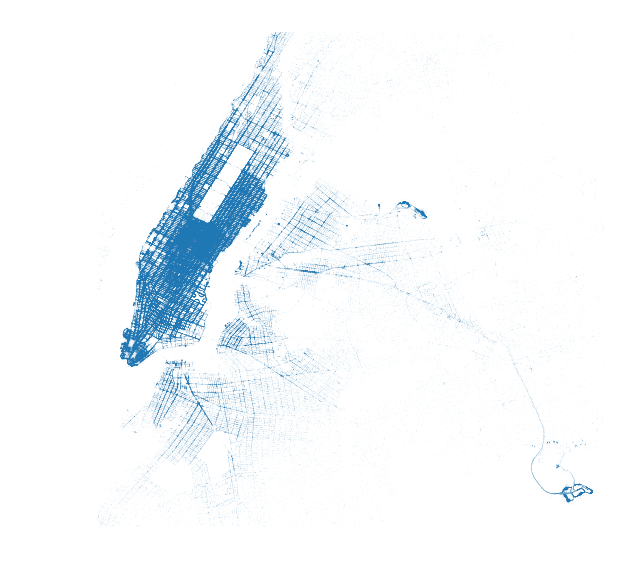

In [24]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize=(10, 10))
plt.plot(longitude, latitude, '.', alpha=0.4, markersize=0.05)
plt.show()

In [25]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

## Cluster
각 택시의 픽업 및 하차 지점을 기준으로 뉴욕 시를 클러스터링 해보겠습니다.

Text(0.5, 1.0, 'Clusters of New York')

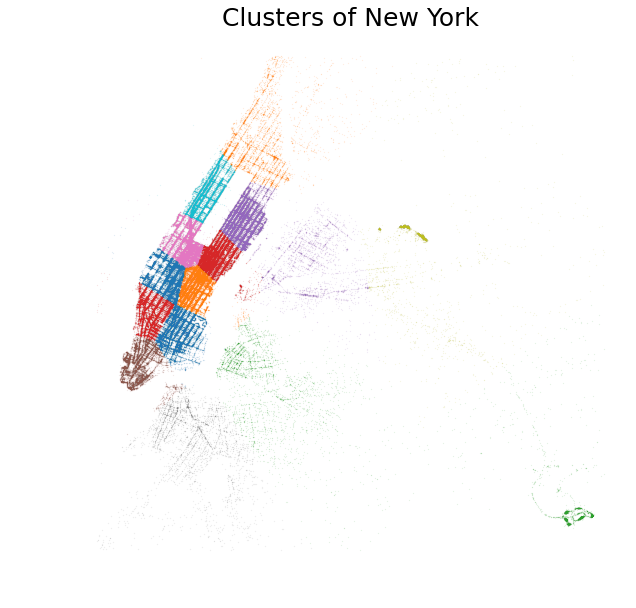

In [27]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init=10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize=(10, 10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label==label], loc_df.latitude[loc_df.label==label],
             '.', alpha=0.3, markersize=0.3)
plt.title('Clusters of New York')

우리가 볼 수 있듯이, 클러스터링은 뉴욕이 분할되는 방식과 다소 유사한 파티션을 만듭니다. 우리는 각각 하늘색과 보라색으로 센트럴 파크 동쪽과 서쪽을 볼 수 있습니다. 파란색은 